In [1]:
import numpy as np
import re as re
import matplotlib.pyplot as plt
import pandas as pd
from math import floor
from sympy import symbols,diff,sympify,lambdify,default_sort_key
from sympy.parsing.sympy_parser import parse_expr

In [179]:
def parse_string_to_sympy(function):
    return parse_expr(function,evaluate=False)

#Retorna a função lambda da expressão sympy. A função irá receber todas as variáveis livres da expressão em forma
#vetorial
#expr - expressão no formato sympy
def vector_lambdify(expr):
    return lambdify(np.array([sorted(list(expr.free_symbols), key = lambda x:x.sort_key())]),expr),len(list(expr.free_symbols))

#Formato do sistema:
#[0] EDO em formato string (e.g. "y'(t) = t*y(t)**2" )
#[1] Condição de contorno em formato  string(e.g. "y(0) = 1") 
#return - função lambda do segundo membro da EDO
#       - x0 da condição de contorno
#       - y0 da condição de contorno
def system_pre_processing(system_string):
    members = re.split("=",system_string[0])
    members[1] = re.sub("(?<![a-z])[a-z][(][a-z][)]", "a",members[1])
    left_member_sympy = parse_string_to_sympy(members[1])
    left_member_lambda,n_p = vector_lambdify(left_member_sympy)
    
    system_string[1] = re.sub("\s*", "",system_string[1])
    boundary_cond = re.split("=",system_string[1])
    x0 = re.search(r"[a-z][(][0-9][)]",boundary_cond[0])
    x0 = re.sub(r"[a-z][(]","",x0.group(0))
    x0 = re.sub(r"[)]","",x0)
    y0 = re.search(r"[0-9]",boundary_cond[1])
    
    return(left_member_lambda,x0,y0.group(0),n_p)
    
    
def solve_by_euler(f_lambda,t0,x0,range_limit,nbr_points,n_p):
    t= np.arange(t0,range_limit,range_limit/nbr_points)
    h = (range_limit - t0)/nbr_points
    
    x = np.empty(nbr_points)
    x[0] = x0
    
    if (n_p == 2):
        step = lambda x,t: h*(f_lambda([x,t])) + x
        for i in range(1,nbr_points):
            x[i] = step(x[i-1],t[i-1])
    else:
        step = lambda x: h*(f_lambda(x)) + x
        for i in range(1,nbr_points):
            x[i] = step(x[i-1])
    
    return t,x 

def solve_by_rk2(f_t,t0,x0,range_limit,nbr_points,n_p):
    t = np.arange(t0,range_limit,range_limit/nbr_points)
    h = (range_limit - t0)/nbr_points
    
    x = np.empty(nbr_points)
    x[0] = x0
    
    K = lambda x,t,h:(
             lambda K1:(
                 lambda K2: (h/2)*(K1+K2)
                 )(f_t([x + h*K1/2,t + h]))
             )(f_t([x,t]))

    for i in range(1,nbr_points):
        x[i] = x[i-1] + K(x[i-1],t[i-1],h)
    
    return t,x
    
def solve_by_rk4(f_t,t0,x0,range_limit,nbr_points,n_p):
    t = np.arange(t0,range_limit,range_limit/nbr_points)
    h = (range_limit - t0)/nbr_points
    
    x = np.empty(nbr_points)
    x[0] = x0
    
    K = lambda x,t,h:(
             lambda K1:(
                 lambda K2:(
                     lambda K3:(
                         lambda K4: (h/6)*(K1 + 2*K2 + 2*K3 + K4)
                         )(f_t([x + h*K3,t + h]))
                     )(f_t([x + h*K2/2,t + h/2]))
                 )(f_t([x + h*K1/2,t + h/2]))
             )(f_t([x,t]))

    for i in range(1,nbr_points):
        x[i] = x[i-1] + K(x[i-1],t[i-1],h)
    
    return t,x
        

def make_panda_table(x,y,nbr_points,divisions):
    slices = floor(nbr_points/divisions)
    DfsSplit = [pd.DataFrame({'x':x[i*slices:i*slices+slices],
                              'y':y[i*slices:i*slices+slices]},
                             index = np.arange(i*slices,i*slices+slices))
               for i in range(divisions)]
    return DfsSplit
    #return [pd.merge(x,y) for x,y in DfsSplit]
    
def plot_xy_dot(x,y):
    plt.plot(x,y,".")
    plt.show()
    
def compare_plot(x,y,f,x0,range_limit):
    interval = np.arange(x0,range_limit,0.1)
    f_v = np.vectorize(f)
    plt.plot(interval,f_v(interval))
    plot_xy_dot(x,y)
    
def solve_ode(f_system,range_limit,nbr_points,mode,compare_function = ""):
    (f,x0,y0,n_p) = system_pre_processing(f_system)
    if(mode=="euler"):
        x,y = solve_by_euler(f,float(x0),float(y0),range_limit,nbr_points,n_p)
    elif(mode=="rk2"):
        x,y = solve_by_rk2(f,float(x0),float(y0),range_limit,nbr_points,n_p)
    elif(mode=="rk4"):
        x,y = solve_by_rk4(f,float(x0),float(y0),range_limit,nbr_points,n_p)
    else:
        print("Modo Invalido")
        return 
    
    if(compare_function == ""):
        plot_xy_dot(x,y)
    else:
        c_f_sympy = parse_string_to_sympy(compare_function)
        c_f_lambda, _ = vector_lambdify(c_f_sympy)
        compare_plot(x,y,c_f_lambda,float(x0),range_limit)
        
#####################################################
#Métodos EDOs de 2ª ordem
#####################################################
        
        
def solve_by_taylor(f_t,t0,x0,x0l,nber_iter,h):
    t = np.arange(t0,nber_iter*h,h)
    
    x = np.empty(nber_iter)
    x[0] = x0
    
    xl = np.empty(nber_iter)
    xl[0] = x0l
    
    for i in range(0,nber_iter-1):
        xll = f_t([x[i],xl[i],t[i]])
        
        x[i+1] = x[i] + xl[i]*h + (xll/2)*(h**2)
        xl[i+1] = xl[i] + xll*h
        
    return t,x

def solve_by_rkn(f_t,t0,x0,x0l,nber_iter,h):
    t = np.arange(t0,nber_iter*h,h)
    
    x = np.empty(nber_iter)
    x[0] = x0
    
    xl = np.empty(nber_iter)
    xl[0] = x0l
    
    #Formula parcial para cálculo do valor da função
    K = lambda x,xl,t,h:(
             lambda K1:(
                 lambda Q:(
                     lambda K2:(
                         lambda K3: xl + (1/3)*(K1 + K2 + K3)
                         )((h/2)*f_t([x + Q,xl + K2,t + h/2]))
                     )((h/2)*f_t([x + Q,xl + K1,t + h/2]))
                 )((h/2)*(xl + K1/2))
             )((h/2)*f_t([x,xl,t]))
    
    #Formula parcial para cálculo do valor da primeira derivada
    KL = lambda x,xl,t,h:(
             lambda K1:(
                 lambda Q:(
                     lambda K2:(
                         lambda K3:(
                             lambda L:(
                                 lambda K4: (1/3)*(K1 + 2*K2 + 2*K3 + K4)
                                 )((h/2)*f_t([x + L,xl + 2*K3,t + h]))
                             )(h*(xl + K3))
                         )((h/2)*f_t([x + Q,xl + K2,t + h/2]))
                     )((h/2)*f_t([x + Q,xl + K1,t + h/2]))
                 )((h/2)*(xl + K1/2))
             )((h/2)*f_t([x,xl,t]))
    
    
    for i in range(1,nber_iter):
        x[i] = x[i-1] + h*K(x[i-1],xl[i-1],t[i-1],h)
        xl[i] = xl[i-1] + KL(x[i-1],xl[i-1],t[i-1],h)
    
    return t,x


def pre_process_string(x):
    xsides = re.split("=",x)
    xsides[0] = re.sub(r"[+]", "-",xsides[0])
    xsides[0] = re.sub(r"(?<![a-z])[a-z][']{2}[(][a-z][)]\s*[-]", "x''(t) =",xsides[0])
    if(len(xsides) == 2):
        x = xsides[0] + '=' + xsides[1] 
    elif(len(xsides) == 1):
        x = xsides[0]
    xsides = re.split("=",x)

    coef = re.search(r"[0-9]*",xsides[0])

    if (not(coef.group(0) == '')):
        x = '(' + xsides[1] +')/' + coef.group(0)
    else:
        x = xsides[1]

    x = re.sub(r"(?<![a-z])[a-z][(][a-z][)]", "a",x)
    x = re.sub(r"(?<![a-z])[a-z][']{1}[(][a-z][)]", "b",x)

    x = x + ' + 0*a' + ' + 0*b' + ' + 0*t'
    return x

def order_2_system_pre_processing(f_system):
    f_system_processed = pre_process_string(f_system[0])
    f_sympy = parse_string_to_sympy(f_system_processed)
    f_lambda,n = vector_lambdify(f_sympy)
    print(sorted(list(f_sympy.free_symbols), key = lambda x:x.sort_key()))
    
    boundary_cond = re.split("=",f_system[1])
    boundary_cond_diff = re.split("=",f_system[2])
    t0 = re.search(r"[a-z][(][0-9][)]",boundary_cond[0])
    t0 = re.sub(r"[a-z][(]","",t0.group(0))
    t0 = re.sub(r"[)]","",t0)
    x0 = re.search(r"[0-9]",boundary_cond_diff[1])
    x0l = re.search(r"[0-9]",boundary_cond_diff[1])
    print('t0 = ',t0,' x0 = ',x0.group(0),'x0 = ',x0l.group(0))
    
    return(f_lambda,t0,x0.group(0),x0l.group(0))
    
def solve_2nd_order_ode(f_system,nber_iter,h,mode,compare_function = ""):
    (f,t0,x0,x0l) = order_2_system_pre_processing(f_system)
    if(mode=="taylor"):
        x,y = solve_by_taylor(f,float(t0,),float(x0),float(x0l),nber_iter,h)
    elif(mode=="rkn"):
        x,y = solve_by_rkn(f,float(t0),float(x0),float(x0l),nber_iter,h)
    else:
        print("Modo Invalido")
        return 
    
    if(compare_function == ""):
        plot_xy_dot(x,y)
    else:
        c_f_sympy = parse_string_to_sympy(compare_function)
        c_f_lambda, _ = vector_lambdify(c_f_sympy)
        compare_plot(x,y,c_f_lambda,float(x0),range_limit)

Série de Taylor
[a, b, t]
t0 =  0  x0 =  0 x0 =  0


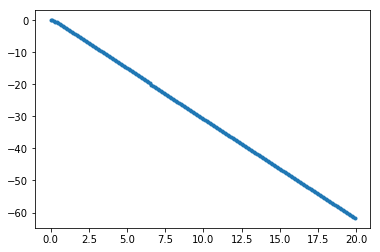

Runge-Kutta-Nyströn
[a, b, t]
t0 =  0  x0 =  0 x0 =  0


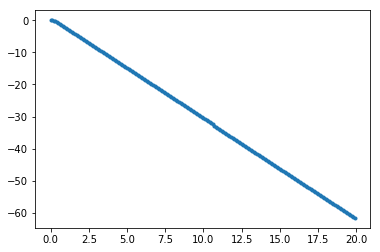

In [209]:
#Modelo queda-livre na água
x = ["z''(t) = -9.8 - z'(t)*Abs(z'(t))","z(0)=0","z'(0)=0"]

print("Série de Taylor")
solve_2nd_order_ode(x,200,0.1,"taylor")
print("Runge-Kutta-Nyströn")
solve_2nd_order_ode(x,200,0.1,"rkn")

Série de Taylor
[a, b, t]
t0 =  0  x0 =  0 x0 =  0


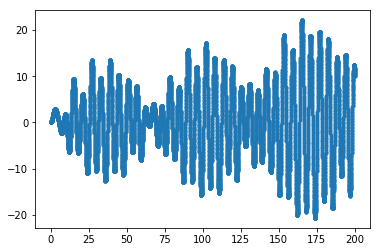

Runge-Kutta-Nyströn
[a, b, t]
t0 =  0  x0 =  0 x0 =  0


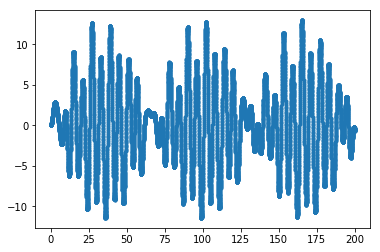

In [233]:
#Exercício 2

x = ["y''(t) = 2*sin(0.5*t) + sin(2*0.5*t) + cos(3*0.5*t) - 0.2*y(t) - y(t)","y(0) = 0", "y'(0) = 0"]

print("Série de Taylor")
solve_2nd_order_ode(x,10000,0.02,"taylor")
print("Runge-Kutta-Nyströn")
solve_2nd_order_ode(x,10000,0.02,"rkn")

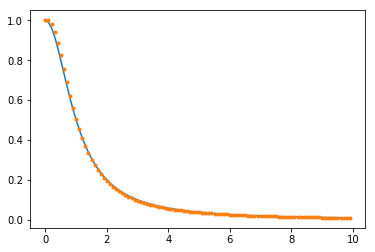

In [3]:
solve_ode(["y'(t) = -2*t*y(t)**2","y(0)=1"],10,100,"euler","1/(1+t**2)")

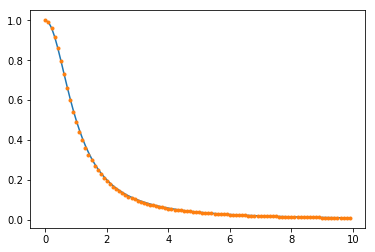

In [4]:
solve_ode(["y'(t) = -2*t*y(t)**2","y(0)=1"],10,100,"rk2","1/(1+t**2)")

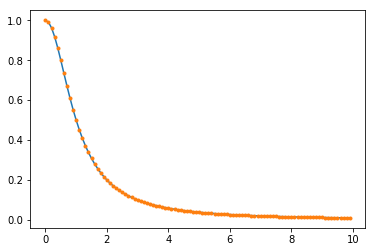

In [5]:
solve_ode(["y'(t) =-2*t*y(t)**2","y(0)=1"],10,100,"rk4","1/(1+t**2)")

In [134]:
x = "z''(t) = -g - z'(t)*abs(z'(t))"

def pre_process_string(f_system):
    xsides = re.split("=",x)
    xsides[0] = re.sub(r"[+]", "-",xsides[0])
    xsides[0] = re.sub(r"(?<![a-z])[a-z][']{2}[(][a-z][)]\s*[-]", "x''(t) =",xsides[0])
    if(len(xsides) == 2):
        x = xsides[0] + '=' + xsides[1] 
    elif(len(xsides) == 1):
        x = xsides[0]
    xsides = re.split("=",x)

    coef = re.search(r"[0-9]*",xsides[0])

    if (not(coef.group(0) == '')):
        x = '(' + xsides[1] +')/' + coef.group(0)
    else:
        x = xsides[1]

    x = re.sub(r"(?<![a-z])[a-z][(][a-z][)]", "a",x)
    x = re.sub(r"(?<![a-z])[a-z][']{1}[(][a-z][)]", "b",x)

    x = x + ' + 0*a' + ' + 0*b' + ' + 0*t'
    return x

z''(t) 
["z''(t) ", " -g - z'(t)*abs(z'(t))"]
["z''(t) ", " -g - z'(t)*abs(z'(t))"]
z''(t) = -g - z'(t)*abs(z'(t))
["z''(t) ", " -g - z'(t)*abs(z'(t))"]
<_sre.SRE_Match object; span=(0, 0), match=''>
 -g - b*abs(b) + 0*a + 0*b + 0*t
